##### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [39]:
!pip install simdkalman

In [50]:
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import simdkalman
from simdkalman import KalmanFilter
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [33]:
df = pd.read_csv('/kaggle/input/th1-gaussion/Gia SMP va SMPcap 2021(Gi th trng SMP).csv',encoding='ISO-8859-1',delimiter=';')
df2 = np.loadtxt("/kaggle/input/th1-gaussion/Gia SMP va SMPcap 2021(Gi th trng SMP).csv",encoding='latin-1', delimiter=';', skiprows=1, usecols=(14,15,16), dtype=float)

In [5]:
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [8]:
feats=['14','15','16']

In [9]:
samples=df[feats]

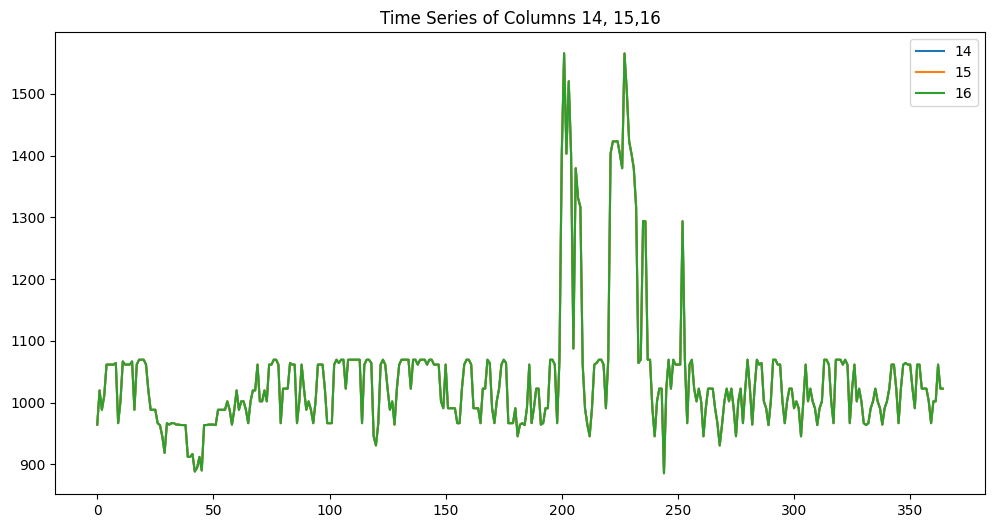

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df['14'], label='14')
plt.plot(df['15'], label='15')
plt.plot(df['16'], label='16')
plt.legend()
plt.title('Time Series of Columns 14, 15,16')
plt.show()

In [41]:
kf = simdkalman.KalmanFilter(
    state_transition = [[1,1],[0,1]],        # matrix A
    process_noise = np.diag([0.1, 0.01]),    # Q
    observation_model = np.array([[1,0]]),   # H
    observation_noise = 1.0)  

In [42]:
x = np.zeros((3, 1)) 

P = np.eye(3)

F = np.eye(3)

H = np.eye(3)

Q = np.eye(3) * 0.01

R = np.eye(3) * 0.1

z = np.zeros((3, 1))

In [43]:
def predict(x, P, F, Q):
    x = np.dot(F, x)
    P = np.dot(F, np.dot(P, F.T)) + Q
    return x, P

def update(x, P, z, H, R):
    y = z - np.dot(H, x)
    S = np.dot(H, np.dot(P, H.T)) + R
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))
    x = x + np.dot(K, y)
    P = P - np.dot(K, np.dot(H, P))
    return x, P

In [44]:
filtered_data = []

for measurement in df2:
    z = measurement.reshape(3, 1)

    x, P = predict(x, P, F, Q)

    x, P = update(x, P, z, H, R)

    filtered_data.append(x.flatten())

filtered_data = np.array(filtered_data)

In [47]:
mse_kalman = mean_squared_error(df2, filtered_data)
mae_kalman = mean_absolute_error(df2, filtered_data)
rmse_kalman = np.sqrt(mse_kalman)
r2_kalman = r2_score(df2, filtered_data)

print("MSE:", mse_kalman)
print("MAE:", mae_kalman)
print("RMSE:", rmse_kalman)
print("R2:",r2_kalman)

MSE: 2795.543314793346
MAE: 32.44236277623181
RMSE: 52.87289773403143
R2: 0.7464377805128212


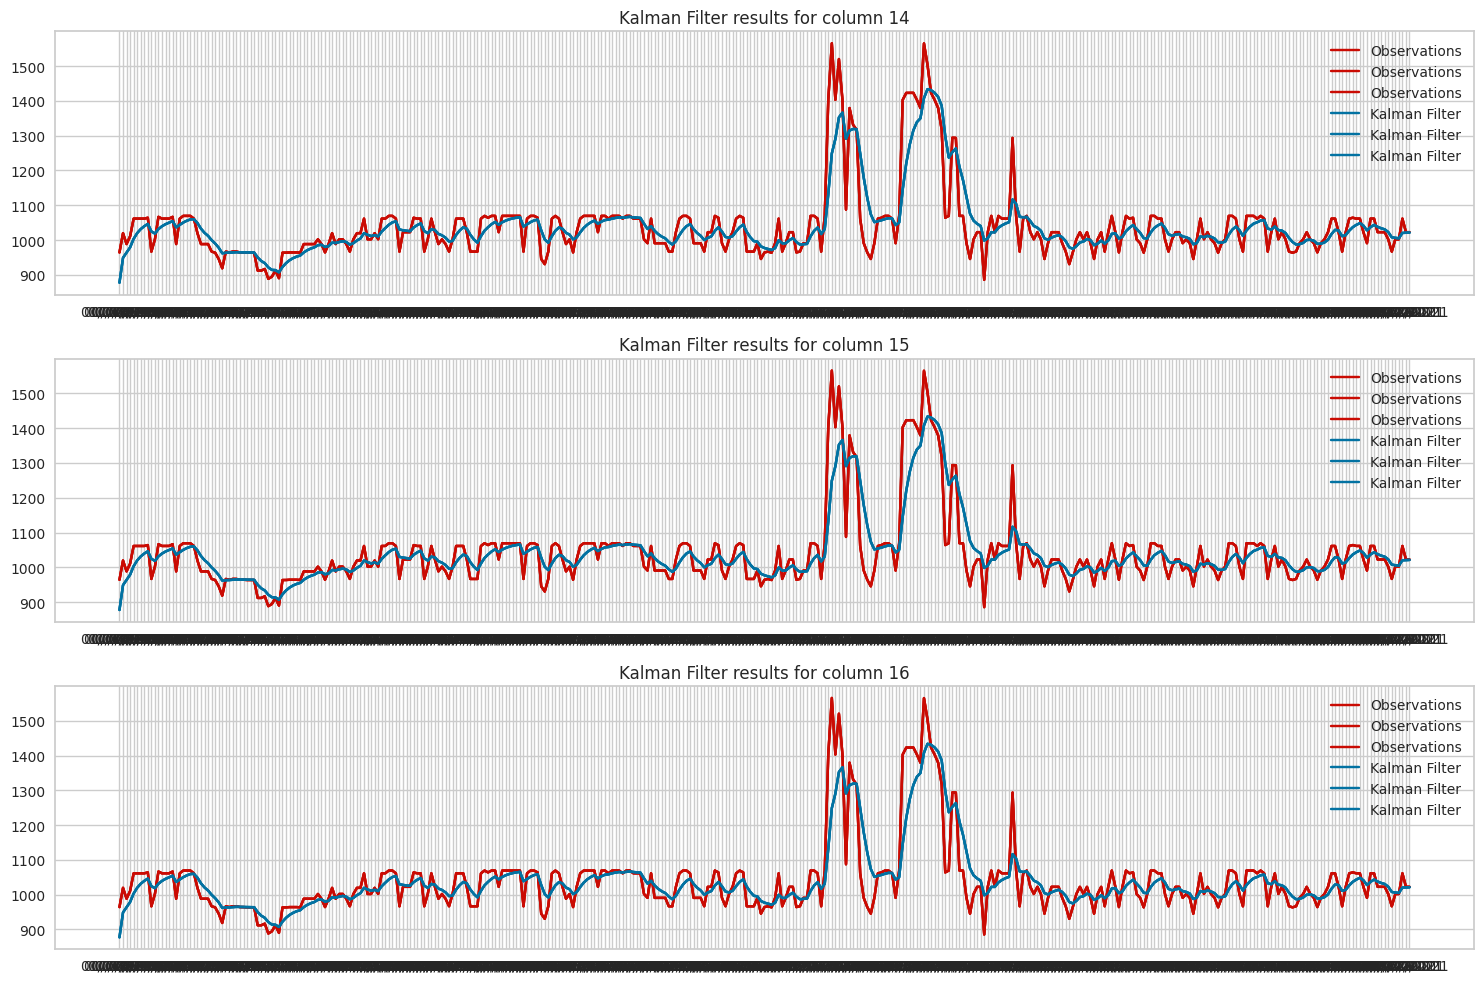

In [60]:
# Plot the results for each column
plt.figure(figsize=(15, 10))

for i, col in enumerate(feats):
    plt.subplot(len(feats), 1, i+1)
    plt.plot(df['Ngày'], df[feats], 'r', label='Observations')
    plt.plot(df['Ngày'], filtered_data, 'b', label='Kalman Filter')
    plt.title(f'Kalman Filter results for column {col}')
    plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Khởi tạo HMM
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)

# Huấn luyện HMM với dữ liệu quan sát
model.fit(df2)

# In ra các tham số của mô hình sau khi huấn luyện
print("Start probabilities: ", model.startprob_)
print("Transition matrix: ", model.transmat_)
print("Means: ", model.means_)
print("Covariances: ", model.covars_)

Start probabilities:  [9.99999997e-01 2.68484017e-09]
Transition matrix:  [[0.12522176 0.87477824]
 [0.08140694 0.91859306]]
Means:  [[1002.30717001 1002.39145081 1002.39457232]
 [1043.97135369 1043.97135369 1043.97585867]]
Covariances:  [[[ 1791.47025481  1792.8421789   1792.58119813]
  [ 1792.8421789   1794.21667642  1793.95512042]
  [ 1792.58119813  1793.95512042  1793.69386682]]

 [[11761.41494514 11761.41494514 11761.3442558 ]
  [11761.41494514 11761.41494514 11761.3442558 ]
  [11761.3442558  11761.3442558  11761.27411679]]]


In [62]:
# Dự đoán trạng thái ẩn cho các quan sát hiện có
hidden_states = model.predict(df2)
print("Hidden states: ", hidden_states)

# Lấy mẫu mới từ mô hình đã huấn luyện
X, Z = model.sample(10)  # Lấy mẫu 5 quan sát mới
print("Sampled observations: ", X)
print("Sampled hidden states: ", Z)

Hidden states:  [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
Sampled observations:  [[1004.77673748 1004.8094023  1004.83284251]
 [1067.21062892 1067.21062836 1067.22501502]
 [1154.29493059 1154.29493304 1154.31345293]
 [1054.02153587 1054.0215355  1054.00219317]
 [1141.29700829 1141.29701028 1141.27875

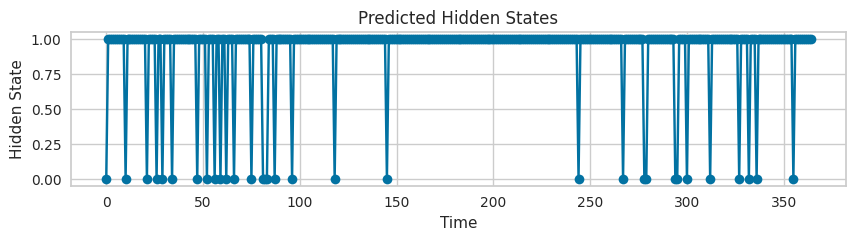

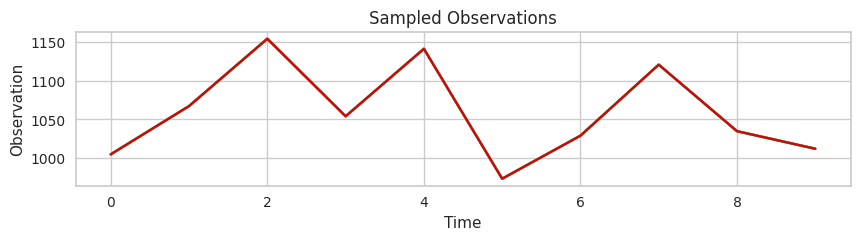

In [63]:
# Vẽ các trạng thái ẩn dự đoán
def plot_hidden_states(hidden_states, title):
    plt.figure(figsize=(10, 2))
    plt.plot(hidden_states, marker='o')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Hidden State")
    plt.show()

plot_hidden_states(hidden_states, "Predicted Hidden States")

# Vẽ các quan sát mẫu
def plot_observations(observations, title):
    plt.figure(figsize=(10, 2)) 
    plt.plot(observations)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Observation")
    plt.show()

plot_observations(X, "Sampled Observations")

In [70]:
state2color = {} 
state2color['14'] = 'blue'
state2color['15'] = 'grey'
state2color['16'] = 'orange'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    
plot_weather_samples(samples, state2color)

KeyError: 934.969049794554